# Analisi dati per l'esperienza di Michelson

Cose da fare:
- aggiungere l'analisi delle probabilità

## Import

### Import delle librerie

In [348]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scienceplots
from colorama import Fore, Style

plt.style.use(["science", "ieee"])

### Import dei dati

Per ogni sezione dell'esperimento viene caricato un foglio del file excel `Dati_raccolti.xlsx`, in cui sono contenuti solo i valori utili all'analisi statistica dei dati.
A questo punti i dati sono contenuti in un dataframe di Pandas, ovvero una sorta di matrice.

Puliamo i dati, eliminando le righe contenenti solo zeri (`<df>[(<df>.T != 0).any()]`), poi trasponiamo la matrice (`.T`) e la convertiamo un un array di Numpy bidimensionale (`.to_numpy()`).

Infine mostriamo i dati per controllare non si siano verificati errori durante il processo.

In [349]:
f_name = "Dati_raccolti.xlsx"

lambda_data = pd.read_excel(f_name, sheet_name="Export_lambda", header=None)
lambda_data = lambda_data[(lambda_data.T != 0).any()].T.to_numpy()

n_a_data = pd.read_excel(f_name, sheet_name="Export_n", header=None)
n_a_data = n_a_data[(n_a_data.T != 0).any()].T.to_numpy()

white_data = pd.read_excel(f_name, sheet_name="Export_white", header=None)
white_data = white_data[(white_data.T != 0).any()].T.to_numpy()

sodio_data = pd.read_excel(f_name, sheet_name="Export_Na", header=None)
sodio_data = sodio_data[(sodio_data.T != 0).any()].T.to_numpy()

# remove unused variable
del f_name

### Funzioni statistiche

In [350]:
def weighted_avg_and_std(values: np.ndarray, weights: np.ndarray) -> Tuple[float]:
    # Return the weighted average and standard deviation.
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)
    return (average, np.sqrt(variance))

## Misura di $\lambda$

In [351]:
dx = (lambda_data[1] - lambda_data[0]) / 5  # mm (/5 per la leva)
N1 = lambda_data[2]  # no unità di misura
dx_err = np.sqrt(2) * 1e-3  # mm (errore sui dx)

# show data
print("Spostamenti trovati [mm]: ", dx)
print("Massimi di interferenza trovati (N1): ", N1)


def calc_lambdas() -> np.ndarray[float]:
    # assumendo n_aria = 1
    return 2 * np.divide(dx, N1)  # mm


lambdas = calc_lambdas()
mean_lambda, std_lambda = weighted_avg_and_std(lambdas, 2 * np.divide(dx, N1))

# Show lambda approssimato
print(
    Fore.GREEN
    + Style.BRIGHT
    + f"Valore di lambda: {mean_lambda*1e6:.4g} ±{std_lambda*1e6:.2g} nm"
)

print(lambdas)

# remove unused variable
del lambda_data

Spostamenti trovati [mm]:  [0.042 0.04  0.04  0.04  0.042 0.04 ]
Massimi di interferenza trovati (N1):  [130. 128. 130. 130. 134. 133.]
Valore di lambda: 622 ±14 nm
[0.00064615 0.000625   0.00061538 0.00061538 0.00062687 0.0006015 ]


## Misura di $n_a$

In [352]:
N2 = n_a_data[0, :]  # no unità di misura
D = n_a_data[1, 0]  # mm


# show data
print("Massimi di interferenza trovati (N2): ", N2)
print(f"Valore nominale della camera a vuoto: {D:.4g}mm")


def calc_refraction_index() -> np.ndarray[float]:
    return 1 + N2 * mean_lambda / (2 * D)  # no unità di misura


n_as = calc_refraction_index()
n_as_err = np.multiply(
    np.sqrt(np.square(2 / N2) + np.square(std_lambda / mean_lambda)),
    n_as,
)


mean_n_a, std_n_a = weighted_avg_and_std(n_as, n_as_err)

# show n_a approssimato
print(Fore.GREEN + Style.BRIGHT + f"Valore di n_aria: {mean_n_a:_.7g} ±{std_n_a:.3g}")

# remove unused variables
del n_a_data, lambdas, n_as, n_as_err

Massimi di interferenza trovati (N2):  [42 42 42 43 41 42]
Valore nominale della camera a vuoto: 50mm
Valore di n_aria: 1.000261 ±3.59e-06


## Sistema lineare in $\lambda$ e $n_a$

### Calcolo utilizzando i valori medi di N1, N2 e dx

In [353]:
def sis_lin_medie(N1=np.mean(N1), N2=np.mean(N2), dx=np.mean(dx)) -> Tuple[float]:
    # return (lambda, n_a) dai valor medi di N1, N2, dx
    return 2 * dx * D / (N1 * D - dx * N2), N1 * D / (N1 * D - dx * N2)


def sis_lin_err(N1: np.ndarray, N2: np.ndarray, dx: np.ndarray) -> Tuple[float]:
    # return (lambda_err, n_a_err) dai valor medi di N1, N2, dx
    e_N1, e_N2, e_dx = np.std(N1, ddof=1), np.std(N2, ddof=1), np.std(dx, ddof=1)
    N1, N2, dx = np.mean(N1), np.mean(N2), np.mean(dx)
    c = np.square(D / np.square(N1 * D - dx * N2))
    return (
        2
        * c
        * np.sqrt(
            np.square(dx * D * e_N1)
            + np.square(dx**2 * e_N2)
            + np.square((N1 * D - 2 * dx * N2) * e_dx)
            # ! manca la covarianza N1 - dx
        ),
        c
        * np.sqrt(
            np.square((2 * N1 * D - dx * N2) * e_N1)
            + np.square(N1 * dx * e_N2)
            + np.square(N1 * N2 * e_dx)
            # ! manca la covarianza N1 - dx
        ),
    )


mean_lambda_sis, mean_n_a_sis = sis_lin_medie()
std_lambda_sis, std_n_a_sis = sis_lin_err(N1, N2, dx)

### calcolo con le varie combinazioni di (N1, dx) x N2

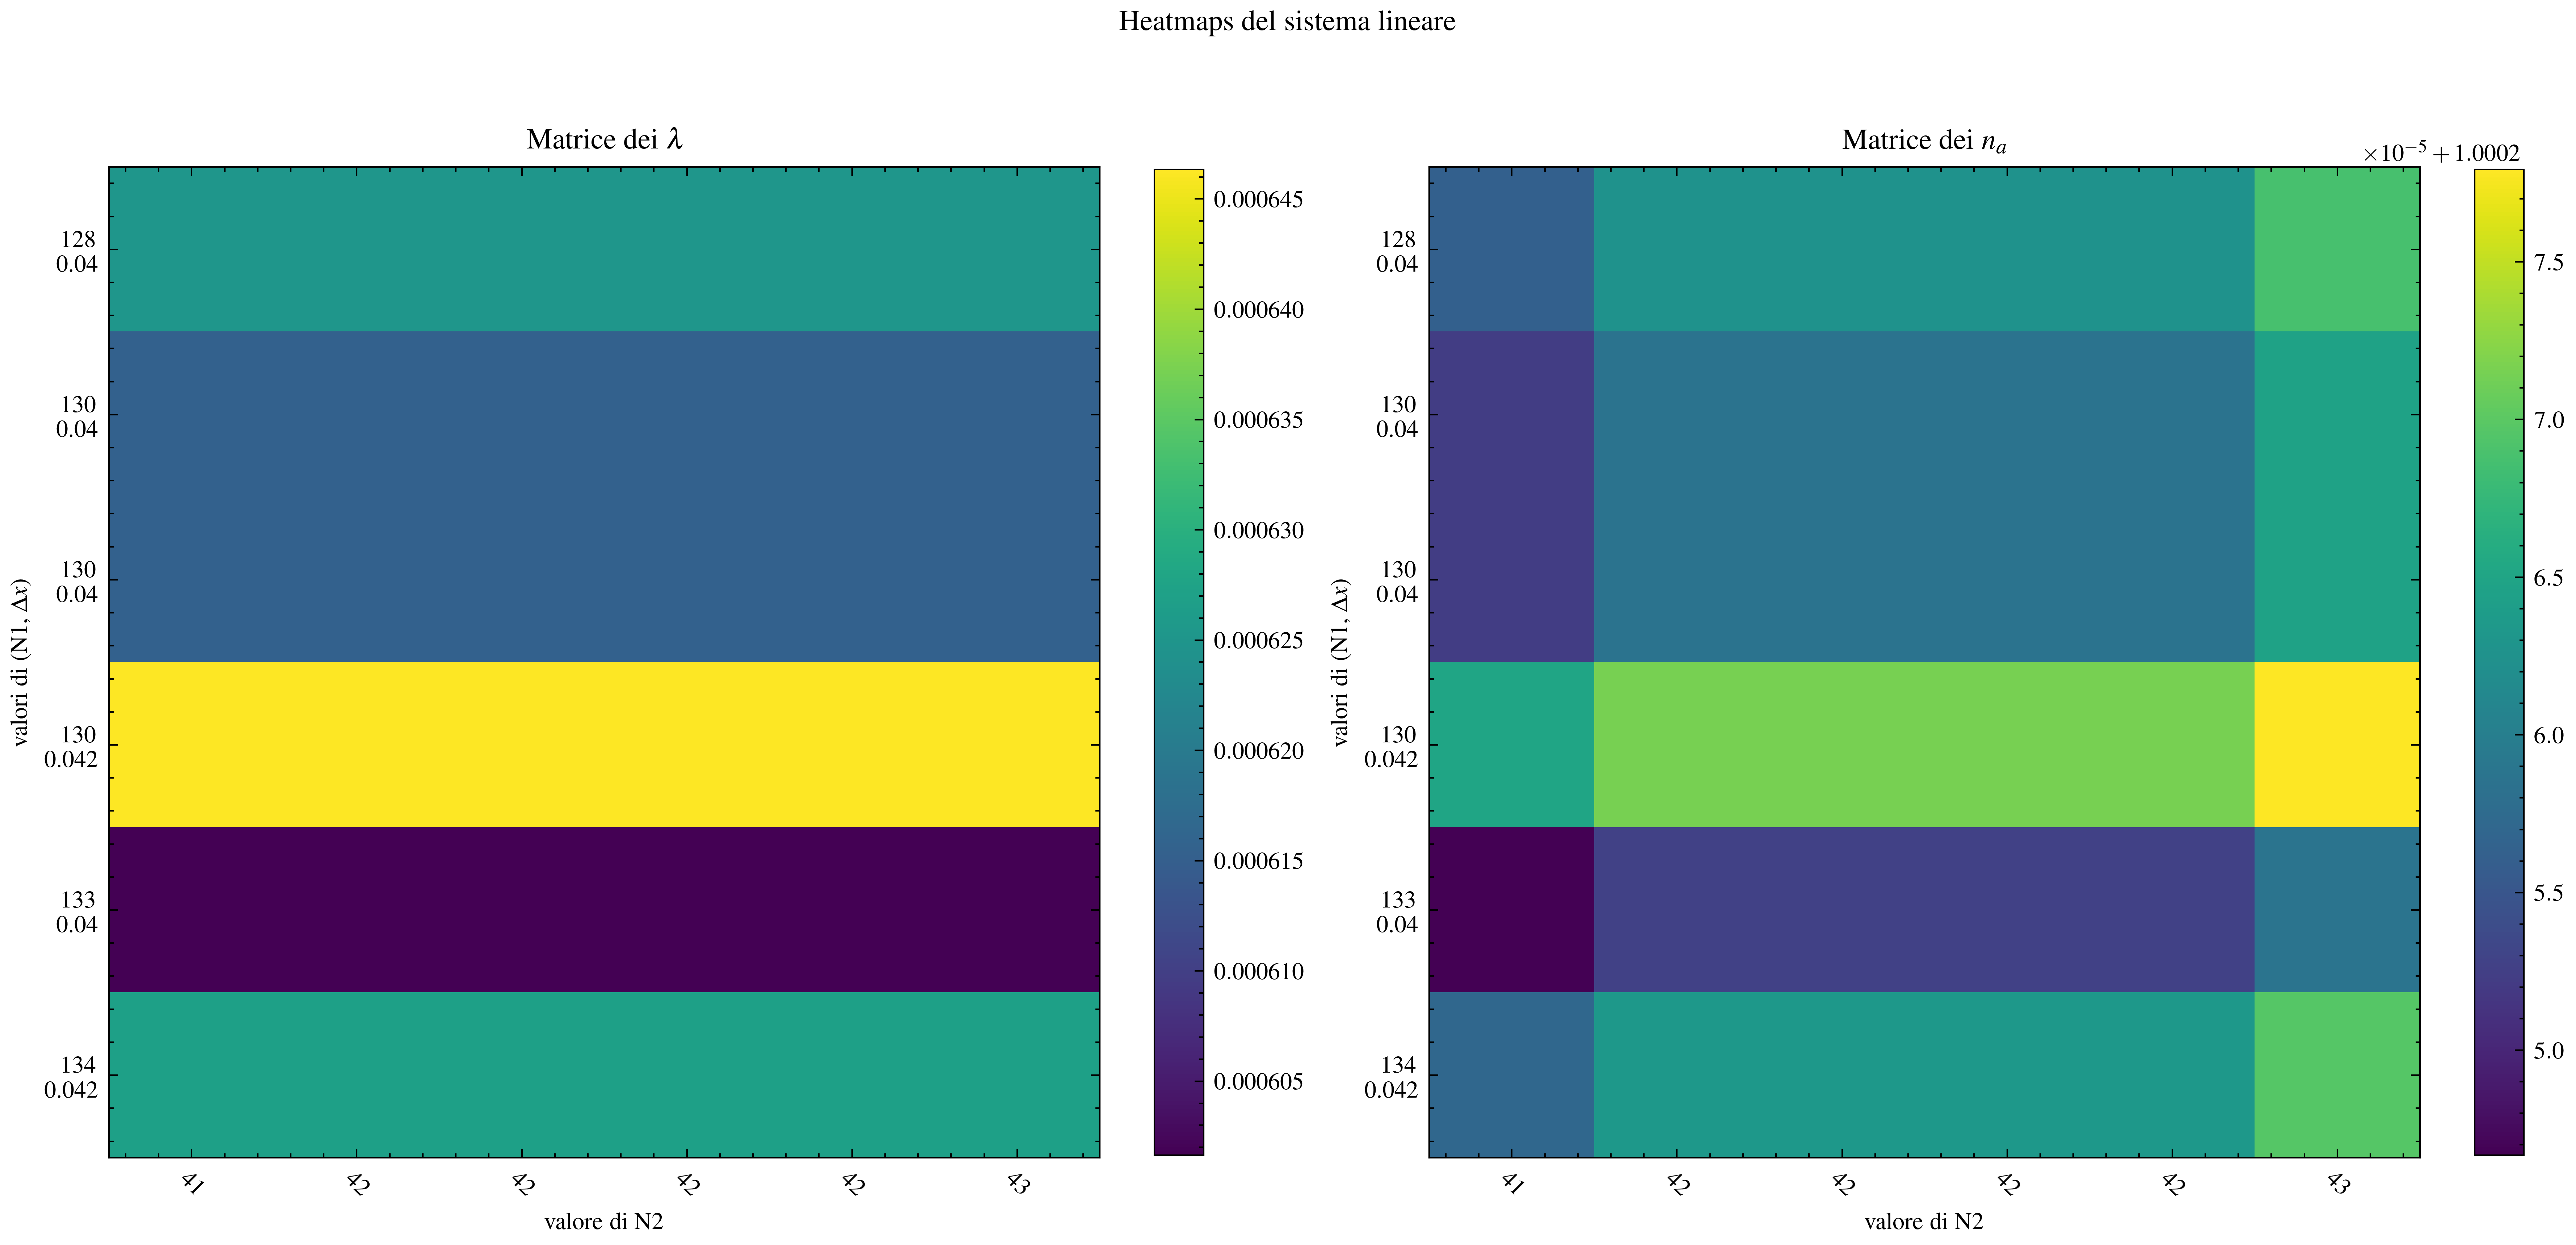

Matrice dei lambda:
[[0.00062516 0.00062516 0.00062516 0.00062516 0.00062516 0.00062517]
 [0.00061554 0.00061554 0.00061554 0.00061554 0.00061554 0.00061555]
 [0.00061554 0.00061554 0.00061554 0.00061554 0.00061554 0.00061555]
 [0.00064633 0.00064633 0.00064633 0.00064633 0.00064633 0.00064633]
 [0.00060165 0.00060166 0.00060166 0.00060166 0.00060166 0.00060166]
 [0.00062703 0.00062703 0.00062703 0.00062703 0.00062703 0.00062703]]
Matrice degli indici di rifrazione:
[[1.00025632 1.00026257 1.00026257 1.00026257 1.00026257 1.00026882]
 [1.00025237 1.00025853 1.00025853 1.00025853 1.00025853 1.00026469]
 [1.00025237 1.00025853 1.00025853 1.00025853 1.00025853 1.00026469]
 [1.00026499 1.00027146 1.00027146 1.00027146 1.00027146 1.00027792]
 [1.00024668 1.0002527  1.0002527  1.0002527  1.0002527  1.00025871]
 [1.00025708 1.00026335 1.00026335 1.00026335 1.00026335 1.00026962]]


In [354]:
def sis_lineare_heatmap() -> Tuple[np.ndarray[float]]:
    M_lambda = np.zeros((len(N1), len(N2)))
    M_n_a = np.zeros((len(N1), len(N2)))

    # Il doppio sort è per avere N1 in ordine e a parità di N1 ordinato per dx
    lambda_zip = sorted(zip(N1, dx), key=lambda x: x[1])
    lambda_zip = sorted(lambda_zip, key=lambda x: x[0])
    sorted_N2 = sorted(N2)

    for i, i_zip in enumerate(lambda_zip):
        i_N1, i_dx = i_zip
        for j, j_N2 in enumerate(sorted_N2):
            M_lambda[i, j], M_n_a[i, j] = sis_lin_medie(N1=i_N1, N2=j_N2, dx=i_dx)

    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
    im = [None, None]
    for i in range(2):
        im[i] = axes[i].imshow(M_lambda if not i else M_n_a)
        axes[i].set_title(f"Matrice dei {r'$\lambda$' if not i else r'$n_a$'}")
        axes[i].set_xlabel("valore di N2")
        axes[i].set_ylabel(r"valori di (N1, $\Delta x$)")
        axes[i].set_xticks(
            np.arange(len(N2)), [f"{n:.3g}" for n in sorted_N2], rotation=-45
        )
        axes[i].set_yticks(
            np.arange(len(N1)), [f"{_n:.3g}\n{_dx:.3g}" for _n, _dx in lambda_zip]
        )
        plt.colorbar(im[i], fraction=0.045, ax=axes[i])

    plt.suptitle("Heatmaps del sistema lineare")
    plt.tight_layout()
    plt.show()

    return M_lambda, M_n_a


M_lambda, M_n_a = sis_lineare_heatmap()

# show matrices
print(Style.BRIGHT + "Matrice dei lambda:" + Style.RESET_ALL)
print(M_lambda)
print(Style.BRIGHT + "Matrice degli indici di rifrazione:" + Style.RESET_ALL)
print(M_n_a)

mean_lambda_M, std_lambda_M = M_lambda.flatten().mean(), M_lambda.flatten().std(ddof=1)
mean_n_a_M, std_n_a_M = M_n_a.flatten().mean(), M_n_a.flatten().std(ddof=1)

# remove unused variables
del M_lambda, M_n_a

### confronto tra tutti i $\lambda$ e $n_a$ trovati

In [355]:
print(
    Fore.GREEN
    + Style.BRIGHT
    + r"Confronto tra lambda e n_aria trovati con i vari modi"
    + Style.RESET_ALL
)
print(Style.BRIGHT + r"Media dei valori trovati separatamente" + Style.RESET_ALL)
print(
    rf"lambda = {mean_lambda*1e6:.4g} ±{std_lambda*1e6:.3g} nm"
    + "\n"
    + rf"n_aria = {mean_n_a:.7g} ±{std_n_a:.3g}"
)
print(Style.BRIGHT + r"Valori trovati dal sistema delle medie" + Style.RESET_ALL)
print(
    rf"lambda = {mean_lambda_sis*1e6:.4g} ±{std_lambda_sis*1e6:.3g} nm"
    + "\n"
    + rf"n_aria = {mean_n_a_sis:.7g} ±{std_n_a_sis:.3g}"
)
print(
    Style.BRIGHT
    + r"Valori trovati dalla media del sistema di combinazioni"
    + Style.RESET_ALL
)
print(
    rf"lambda = {mean_lambda_M*1e6:.4g} ±{std_lambda_M*1e6:.3g} nm"
    + "\n"
    + rf"n_aria = {mean_n_a_M:.7g} ±{std_n_a_M:.3g}"
)

Confronto tra lambda e n_aria trovati con i vari modi
Media dei valori trovati separatamente
lambda = 622 ±13.7 nm
n_aria = 1.000261 ±3.59e-06
Valori trovati dal sistema delle medie
lambda = 621.8 ±2.22e-05 nm
n_aria = 1.000261 ±3.98e-08
Valori trovati dalla media del sistema di combinazioni
lambda = 621.9 ±13.9 nm
n_aria = 1.000261 ±6.88e-06


### Misura dei treni d'onda

In [356]:
dx = (white_data[1, :] - white_data[0, :]) / 5  # mm

# show data
print("Spostamenti trovati [mm]: ", dx)

Lp = 2 * dx

mean_Lp = Lp.mean()
std_Lp = 2 * dx_err

mean_dlambda = mean_lambda_M**2 / mean_Lp  # ? quale lambda?
std_dlambda = mean_dlambda * np.sqrt(
    np.square(2 * np.divide(std_lambda_M, mean_lambda_M)) + np.square(std_Lp / mean_Lp)
)

print(
    Fore.GREEN
    + Style.BRIGHT
    + "Valore della lunghezza di un pacchetto di luce bianca:"
    + f" {mean_dlambda *1e6:_.7g} ±{std_dlambda*1e6:.3g} nm"
)

# remove unused data
del white_data

Spostamenti trovati [mm]:  [0.024 0.026 0.024 0.024 0.026 0.026]
Valore della lunghezza di un pacchetto di luce bianca: 7.734642 ±0.557 nm


### Misura della separazione del doppietto del sodio

In [357]:
dx = (sodio_data[2, :] - sodio_data[1, :]) / 5
m = sodio_data[0, :]

# show data
print("Spostamenti trovati [mm]: ", dx)
print("All'ordine: ", m)


D_lambdas = (5893e-7) ** 2 * np.divide(m, 2 * dx)  # mm

mean_D_lambda = D_lambdas.mean()
std_D_lambda = D_lambdas.std(ddof=1)


print(
    Fore.GREEN
    + Style.BRIGHT
    + "Valore della separazione del doppietto del sodio:"
    + f" {mean_D_lambda *1e7:_.3g} ±{std_D_lambda*1e7:.2g} Å"
)

# remove unused variables
del sodio_data

Spostamenti trovati [mm]:  [0.72  0.81  0.95  0.296 0.276 1.422 0.596 0.56 ]
All'ordine:  [3. 3. 4. 1. 1. 5. 2. 2.]
Valore della separazione del doppietto del sodio: 6.41 ±0.57 Å


## Analisi statistica

In questa sezione vi saranno tutte le probabilità che dovremo calcolare con t-student e $\chi^2$.